In [549]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [550]:
# Setup duckdb connection
DB_PATH = '../data/db/master.db'
con = duckdb.connect(DB_PATH)

In [551]:
# phhs data is split into 3 tables 
con.sql('show tables;').show()

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ actions │
│ hands   │
│ players │
└─────────┘



In [552]:
# `hands` contains a row of all the scalar fields from each parsed hand
con.sql('select * from hands limit 5;').show()

┌────────────┬─────────┬──────────┬───────────┬─────────┬─────────┬─────────────┬─────────────┬────────────────┬─────────────┐
│  hand_id   │ variant │ bring_in │ small_bet │ big_bet │ min_bet │ num_players │ num_actions │     venue      │    table    │
│   int64    │ varchar │  double  │  double   │ double  │ double  │    int64    │    int64    │    varchar     │   varchar   │
├────────────┼─────────┼──────────┼───────────┼─────────┼─────────┼─────────────┼─────────────┼────────────────┼─────────────┤
│ 3031784372 │ NT      │     NULL │      NULL │    NULL │     6.0 │           5 │          26 │ Absolute Poker │ GUMWOOD AVE │
│ 3031789328 │ NT      │     NULL │      NULL │    NULL │     6.0 │           6 │          25 │ Absolute Poker │ GUMWOOD AVE │
│ 3031791000 │ NT      │     NULL │      NULL │    NULL │     6.0 │           6 │          27 │ Absolute Poker │ GUMWOOD AVE │
│ 3031797518 │ NT      │     NULL │      NULL │    NULL │     6.0 │           6 │          27 │ Absolute Poker 

In [553]:
# `players` contains a row for each player in each hand, containing information specific to each player
con.sql('select * from players where hand_id = 3031784372;').show()

┌────────────┬────────┬───────────────────┬────────────────────────┬────────────┬───────┬────────────────┬─────────────────┬────────────┐
│  hand_id   │  ante  │ blind_or_straddle │          name          │ player_idx │ seat  │ starting_stack │ finishing_stack │ amount_won │
│   int64    │ double │      double       │        varchar         │   int64    │ int64 │     double     │     double      │   double   │
├────────────┼────────┼───────────────────┼────────────────────────┼────────────┼───────┼────────────────┼─────────────────┼────────────┤
│ 3031784372 │    0.0 │               3.0 │ dYzGQlQYQnkJl0uVsvJJIg │          1 │     3 │         1318.3 │            NULL │       NULL │
│ 3031784372 │    0.0 │               6.0 │ sSZBJzpy1ZH4aGvCJdw9qw │          2 │     4 │         1307.4 │            NULL │       NULL │
│ 3031784372 │    0.0 │               0.0 │ QE2Vn7Qn2j+IUR+rOKncTA │          3 │     5 │         2086.9 │            NULL │       NULL │
│ 3031784372 │    0.0 │           

In [554]:
# Note that this table is not a list of all players.
# Rather, it stores player-specific information for each hand.
# To illustrate this, we can query from this table all the hands that the player `dYzGQlQYQnkJl0uVsvJJIg` participated in:
con.sql("select distinct hand_id from players where name = 'dYzGQlQYQnkJl0uVsvJJIg';")

┌────────────┐
│  hand_id   │
│   int64    │
├────────────┤
│ 3031834058 │
│ 3031858474 │
│ 3031877064 │
│ 3032024662 │
│ 3031364226 │
│ 3031442588 │
│ 3031527928 │
│ 3031538244 │
│ 3031734280 │
│ 3024749866 │
│      ·     │
│      ·     │
│      ·     │
│ 3017843768 │
│ 3030252388 │
│ 3030459664 │
│ 3025761552 │
│ 3025850772 │
│ 3029612744 │
│ 3029699234 │
│ 3029705428 │
│ 3024667766 │
│ 3024689344 │
├────────────┤
│  237 rows  │
│ (20 shown) │
└────────────┘

In [555]:
# `actions` contains a row for each action in each hand
con.sql('select * from actions where hand_id = 3031784372;').show()

┌────────────┬──────────────┬─────────┬─────────────┬────────┬─────────┬──────────────┐
│  hand_id   │ action_index │  actor  │ action_type │ amount │  cards  │  raw_action  │
│   int64    │    int64     │ varchar │   varchar   │ double │ varchar │   varchar    │
├────────────┼──────────────┼─────────┼─────────────┼────────┼─────────┼──────────────┤
│ 3031784372 │            0 │ d       │ dh          │   NULL │ p1 ???? │ d dh p1 ???? │
│ 3031784372 │            1 │ d       │ dh          │   NULL │ p2 ???? │ d dh p2 ???? │
│ 3031784372 │            2 │ d       │ dh          │   NULL │ p3 ???? │ d dh p3 ???? │
│ 3031784372 │            3 │ d       │ dh          │   NULL │ p4 ???? │ d dh p4 ???? │
│ 3031784372 │            4 │ d       │ dh          │   NULL │ p5 ???? │ d dh p5 ???? │
│ 3031784372 │            5 │ p3      │ f           │   NULL │ NULL    │ p3 f         │
│ 3031784372 │            6 │ p4      │ cbr         │   21.0 │ NULL    │ p4 cbr 21    │
│ 3031784372 │            7 │ p5

In [556]:
# Okay, enough with the basics. Let's answer some questions.
# Q1: Who are the most active players on the site?

query = '''
select
    p.name,
    count(*) as cnt
from players p join hands h on p.hand_id = h.hand_id
group by p.name
order by cnt desc
limit 5;
'''

con.sql(query).show()

┌────────────────────────┬───────┐
│          name          │  cnt  │
│        varchar         │ int64 │
├────────────────────────┼───────┤
│ HQg4dAYPUt6c2wXfx8Qp2A │  5116 │
│ 9kGpt+XUpavowCzDUv23cw │  4984 │
│ igvhUfnIs8in/SlI6b2cug │  3963 │
│ imLtn/9RRisp29uN9gUA1A │  3696 │
│ pwDVQ1QvWrUq1ENAKwtJgw │  3611 │
└────────────────────────┴───────┘



In [557]:
# Q2: What does the distribution of hand lengths look like?

query = '''
select
    num_actions,
    count(*) as cnt
from hands
group by num_actions
'''

num_actions_df = con.sql(query).df()
num_actions_df.head()

,num_actions,cnt
0,4,341
1,5,347
2,6,200
3,7,44
4,8,109


<Axes: xlabel='num_actions', ylabel='cnt'>

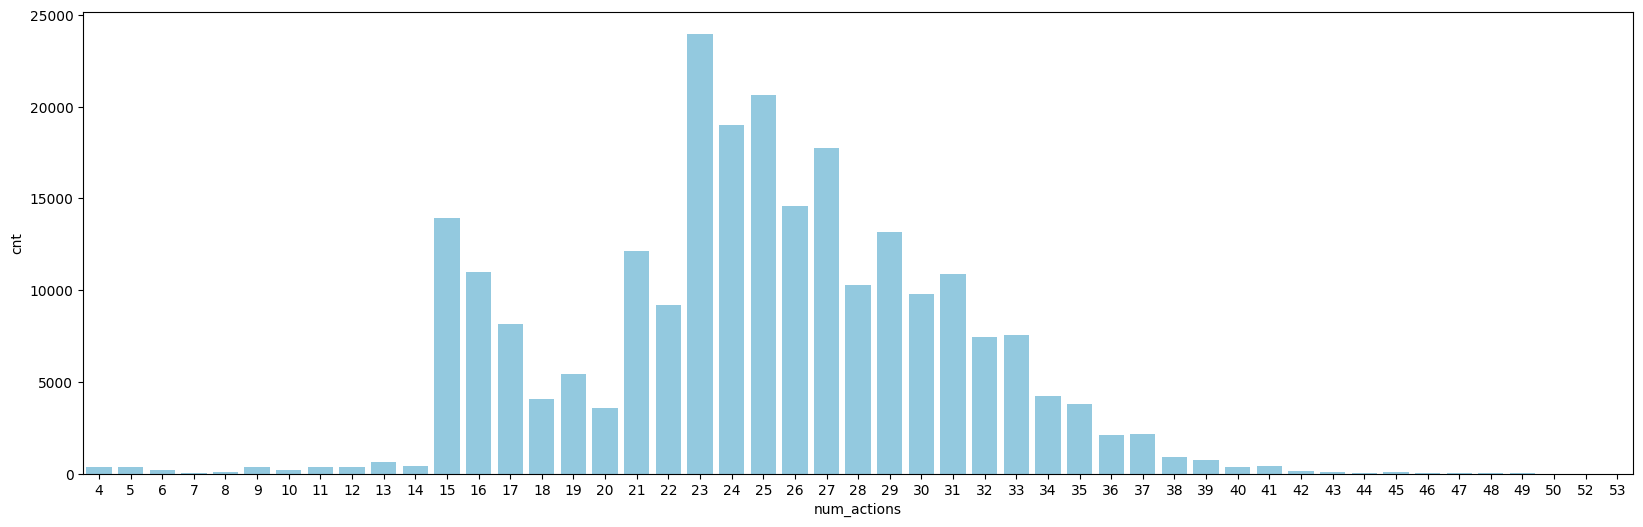

In [558]:
plt.figure(figsize=(20,6))
sns.barplot(x='num_actions', y='cnt', data=num_actions_df, color='skyblue')

In [559]:
# Q3: What does the distribution of VPIP's look like?

query = '''
with flop_index as (
    select hand_id, min(action_index) as flop_action_index
    from actions
    where action_type = 'db' and length(cards) = 6
    group by hand_id
),

preflop_actions as (
    select
        a.hand_id,
        p.name as player_name,
        coalesce(a.amount, 0) as amount,
        coalesce(p.blind_or_straddle, 0) as blind_or_straddle
    from actions a
    join players p
      on a.hand_id = p.hand_id and a.actor = 'p' || cast(p.player_idx as varchar)
    left join flop_index f
      on a.hand_id = f.hand_id
    where a.action_index < coalesce(f.flop_action_index, -1)
),

vpip as (
    select
        hand_id,
        player_name,
        case when sum(case when amount > blind_or_straddle then 1 else 0 end) > 0
             then 1 else 0 end as vpip
    from preflop_actions
    group by hand_id, player_name
)

select
    player_name,
    avg(coalesce(vpip, 0)) as vpip,
    count(distinct hand_id) as sample_size
from vpip
group by player_name
having sample_size >= 200
order by random();
'''

df_vpip = con.sql(query).df()
df_vpip.head()

,player_name,vpip,sample_size
0,6GIiEMXYcGaNeP1XEzZeYg,0.058537,205
1,7o+yGBmGhhCJTc9xZRMwOw,0.185484,248
2,Jt2NLQSv5gW/r/9T3PNsRQ,0.075929,619
3,jnV74ps8tAq/F4Xp+tV7hA,0.062241,241
4,JaEUlMKr4EizDLjc816fTw,0.053601,597


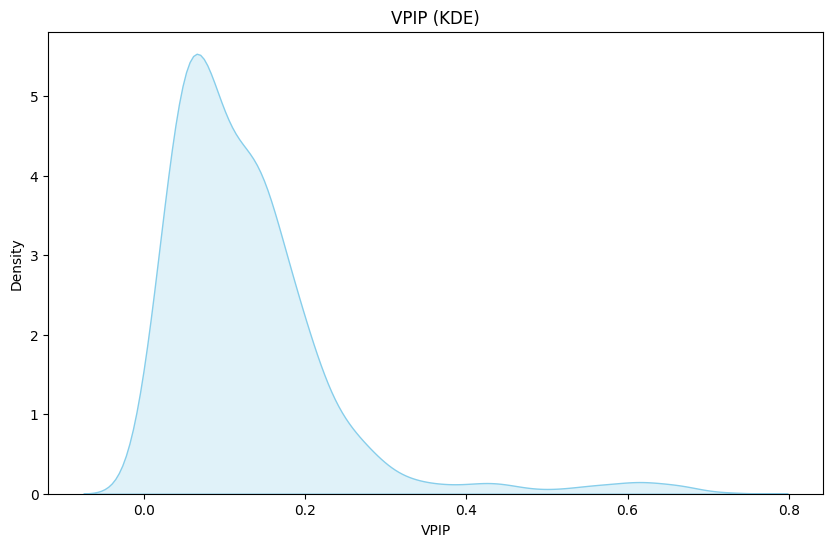

In [560]:
plt.figure(figsize=(10,6))
sns.kdeplot(df_vpip['vpip'], fill=True, color='skyblue')
plt.title('VPIP (KDE)')
plt.xlabel('VPIP')
plt.ylabel('Density')
plt.show()

In [561]:
con.close()